<a href="https://colab.research.google.com/github/eun-woo/seq2seq/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Sep 13 16:59:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |   1318MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!wget https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-09-13 16:59:41--  https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2357401 (2.2M) [text/plain]
Saving to: ‘smilestyle_dataset.tsv.1’

smilestyle_dataset. 100%[===================>]   2.25M  --.-KB/s    in 0.01s   

2022-09-13 16:59:41 (236 MB/s) - ‘smilestyle_dataset.tsv.1’ saved [2357401/2357401]



In [ ]:
from google.colab import drive

drive.mount("/content/drive2")

Drive already mounted at /content/drive2; to attempt to forcibly remount, call drive.mount("/content/drive2", force_remount=True).


In [ ]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from tokenizers import Tokenizer
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display
from typing import Dict

In [ ]:
df = pd.read_csv("smilestyle_dataset.tsv", sep='\t')
df_notna = df.notna().sum(axis=1)

#df = df[df_notna>=2]

df = df.dropna(thresh=2)
df.shape

(3470, 17)

In [ ]:
df = pd.read_csv("smilestyle_dataset.tsv", sep="\t")
display(df.head())
display(df.isna().mean())
display(df.describe())
print(df.shape)

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
0,안녕하세요. 저는 고양이 6마리 키워요.,안녕! 나는 고양이 6마리 키워.,휴먼. 반갑다. 안드로이드는. 고양이. 6마리. 소유중.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하잉ㅋㅋ 나 떼걸룩 6마리 키운다!,ㅎㅇ 나 주인님 6마리 모심 ㅋㅋ,안녕!! >< 나는 고양이😺를 ➏ 마리 키우고있어!! 0_0,안녕안녕~! 나 고양이 6마리나 키운다? 완전 대박이징~,"안녕하십니까,, 저는 고양이 6마리 키웁니다.",안녕하신가~... 난 지금 고양이를 6마리 키우고 있다네,하유 시벌것 괭이놈 6마리 키우는데 힘들어 죽겟네,안녕하냐 ㅡㅡ 나 씹냥이 6마리나 키운다 하;,반갑소. 짐은 고양이를 6마리나 키우오.,안녕하냐니깐! 난 고양이를 6마리 키우고있다니깐!,안녕하시오! 소인은 고양이를 6마리 키우고 있소!,안녕… 난 고양이 6마리 키워 ㅠㅠ,반가운. 나는 6마리의 고양이를 소지하고 있다.
1,고양이를 6마리나요? 키우는거 안 힘드세요?,고양이를 6마리나? 키우는거 안 힘들어?,고양이. 6마리. 양육. 번거로운가.,아니 무슨 고양이를 6마리나? 거 키우는 거 안 힘든가?,엥? 6마리나? 안힘듬?ㅋㅋㅋㅋ,6마리? 에바아니냐 안 힘듦?,고양이를 6마리나?!! w(ﾟДﾟ)w 키우는거 안 힘듬?? (⊙_⊙;),고양이를 6마리나? 완전 대박~ 키우는 거 안 힘들어?!,"고양이를 6마리나 키우십니까? 안 힘드신지,,",고양이를 6마리나? 키우는거 힘들지 않는가?,니기럴 털만 날리는 거 키우기 안 힘들데?,아니 고양이를 6마리나? 안힘드냐?,고양이를 6마리나? 키우는게 수고스럽진 않소?,고양이를 6마리나? 키우는거 힘들지 않냐니깐?,고양이를 6마리나 키우고 있는 것이오? 힘들지 않소?,고양이..6마리나? ㅠ 키우는건 혹시 안힘들어..?,6마리의 고양이? 당신은 그들로부터 지치지 않습니까?
2,제가 워낙 고양이를 좋아해서 크게 힘들진 않아요.,내가 워낙 고양이를 좋아해서 크게 힘들진 않아.,안드로이드. 고양이. 선호. 힘들지. 않음.,내가 또 워~낙에 고양이를 좋아해서 크게 뭐 힘들진 않고,내가 고양이 좋아해서 딱히 안힘듬 ㅋㅋㅋ,ㄱㅊ 나 고양이 환장해서 힘든 것도 모름,뭐 나야 워낙에 고양이 좋아하니까 딱히 안힘드엉! \(@^0^@)/,내가 또 워~낙에 고양이를 좋아하잖아~ 그렇게 크~게 힘들진 않아 ㅎㅎ~,제가 워낙 고양이를 좋아해서 크게 힘들진 않습니다.,내가 워낙에...고양이가 좋아가지고 그렇게 힘들지 않어...^^,옘병 내가 좋아하니까 키워야지 시벌것,고양이 좋아한다고ㅡㅡ 1도 안힘듬 ㅡㅡ,과인은 고양이를 어여삐 어겨 그리 수고스럽진 않소,내가 고양이를 엄청 좋아해서 별로 힘들지 않다니깐!,소인 고양이를 엄청 좋아하기 때문에 별로 힘들지 않소이다.,내가 고양이 워낙 좋아해서..ㅠㅠ 크게 힘들진 않은 것 같아..,나는 고양이의 큰 애호가. 지치지 않는다.
3,가장 나이가 많은 고양이가 어떻게 돼요?,가장 나이가 많은 고양이가 몇 살이야?,제일. 나이많은. 고양이. 나이. 무엇.,그려 가장 나이가 많은 고양이가 몇살이여?,가장 나이 먹은 고양이가 몇살이야?,젤 낡은 고영희가 몇 살임?,가장 나이 먹은 고양인 몇 살이양? (´･ω･`)?,대박대박 완전 대박!! 그럼 제~일 나이 많은 고양이는 몇살이야~?!,가장 나이가 있는 고양이가 몇살입니까?,고양이들 중에서…가장 나이 먹을 애가 몇살인가?...,거 젤 빨리 뒤질 놈이 나이 얼마나 쳐먹었냐,가장 늙은애가 몇살인데,최고령 고양이의 나이는 어떻게 되는가?,가장 나이 많이 먹은 고양이가 몇 살 이냐니깐?!,나이를 가장 많이 먹은 고양이가 몇 살이오?,혹시.. 제일 나이 많은 고양이는.. 몇살이야..?ㅠ,가장 늙은 고양이가 몇 년입니까?
4,여섯 살입니다. 갈색 고양이에요.,여섯 살이야. 갈색 고양이지.,고양이. 갈색. 여섯살.,6살인데 갈색 고양이 있어~,이제 여섯살이고 갈색고양이임!,"6살, 갈색임",여설 살!! ㄱ^o^/ 색깔은 갈색! O(*￣▽￣*)ブ,"6살인 애 있는데, 완전 귀.여.워. 갈색 고양이야 진짜 대박이지?",6살된 갈색 아이가 있습니다.,저…갈색 고양이인데…여섯살이지~..,저 노망난 갈색놈이 6살 뒤룩뒤룩 쳐먹은 놈이여,여섯살 갈색냥인데 왜,여섯 살이오. 갈색 고양이오.,갈색 고양이가 여섯살이라니깐!,여섯 살에 갈색 고양이오,여섯살이야.. 갈색 ㅠㅠ 고양이야..ㅠ,여섯. 고양이는 갈색이다.


formal        0.063428
informal      0.063428
android       0.520918
azae          0.723347
chat          0.063428
choding       0.063428
emoticon      0.514980
enfp          0.544130
gentle        0.540351
halbae        0.515789
halmae        0.726586
joongding     0.063428
king          0.520918
naruto        0.514980
seonbi        0.514980
sosim         0.520918
translator    0.594062
dtype: float64

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
count,3470,3470,1775,1025,3470,3470,1797,1689,1703,1794,1013,3470,1775,1797,1797,1775,1504
unique,3430,3417,1748,1025,3437,3390,1793,1679,1691,1784,1005,3396,1759,1779,1784,1758,1489
top,안녕하세요.,안녕.,반갑다.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하이,왜?,안녕! (ﾉ*･ω･)ﾉ,안뇽~,안녕하십니까,안녕하신가…,왜 땜시?,ㅎㅇ,반갑소.,안녕하냐니깐!,안녕하시오!,안녕..,반가운.
freq,23,25,10,1,13,37,3,6,5,8,4,29,7,9,9,9,9


(3705, 17)


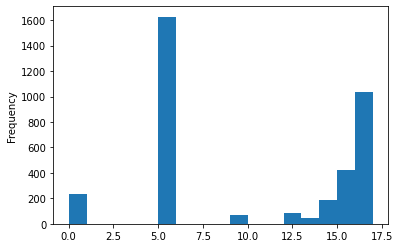

3470


In [ ]:
row_notna_count = df.notna().sum(axis=1)
row_notna_count.plot.hist(bins=row_notna_count.max())
plt.show()

df = df[row_notna_count >= 2]
print(len(df))

In [ ]:
model_name = "gogamza/kobart-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/gogamza/kobart-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/54a37e9385f90886428b084042f151c1a699203416d41765d94aac4cddb5fd5c.d098ef3866c1da94bdfaa5c1f24ecb7c5c16b37423b79263fbd3668d2ae61f91
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "gogamza/kobart-base-v2",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decod

count    36793.000000
mean        13.147582
std          6.909344
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max        318.000000
dtype: float64

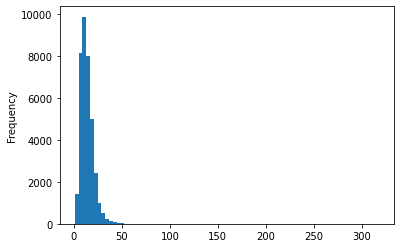

In [ ]:
lengths = []

for column in df.columns:
  out = tokenizer(df[column][df[column].notna()].tolist())
  out = [len(x) for x in out['input_ids']]
  lengths.extend(out)

lengths = pd.Series(lengths)
display(lengths.describe())
lengths.plot.hist(bins=80)

In [ ]:
style_map = {
    'formal': '문어체',
    'informal': '구어체',
    'android': '안드로이드',
    'azae': '아재',
    'chat': '채팅',
    'choding': '초등학생',
    'emoticon': '이모티콘',
    'enfp': 'enfp',
    'gentle': '신사',
    'halbae': '할아버지',
    'halmae': '할머니',
    'joongding': '중학생',
    'king': '왕',
    'naruto': '나루토',
    'seonbi': '선비',
    'sosim': '소심한',
    'translator': '번역기'
}

In [ ]:
class TextStyleTransferDataset(Dataset):
  def __init__(self, 
               df: pd.DataFrame, 
               tokenizer: Tokenizer
               ):
    self.df = df
    self.tokenizer = tokenizer
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index, :].dropna().sample(2)
    text1 = row[0]
    text2 = row[1]
    target_style = row.index[1]
    target_style_name = style_map[target_style]

    encoder_text = f"{target_style_name} 말투로 변환:{text1}"
    decoder_text = f"{text2}{self.tokenizer.eos_token}"
    model_inputs = self.tokenizer(encoder_text, max_length=256, truncation=True)

    with self.tokenizer.as_target_tokenizer():
      labels = tokenizer(decoder_text, max_length=256, truncation=True)
    model_inputs['labels'] = labels['input_ids']
    del model_inputs['token_type_ids']

    return model_inputs

In [ ]:
dataset = TextStyleTransferDataset(df, tokenizer)
out = dataset[0]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

out = dataset[1]
print(out['input_ids'])
print(out['labels'])
print(tokenizer.decode(out['input_ids']))
print(tokenizer.decode(out['labels']))

[14112, 11763, 12687, 14070, 13282, 10338, 14296, 13716, 257, 11699, 9592, 13586, 25161, 16530, 17849, 12034, 14195, 26832, 18712, 14543]
[22465, 232, 14651, 17849, 12034, 14195, 26832, 18712, 245, 1]
구어체 말투로 변환:안녕하세요. 저는 고양이 6마리 키워요.
안녕! 나는 고양이 6마리 키워.</s>
[14081, 19709, 14070, 13282, 10338, 14296, 13716, 257, 9102, 11747, 15188, 14195, 10496, 24665, 14947, 16932, 14082, 14186, 11841, 262, 15994, 12332, 14076, 11319, 262]
[17849, 12034, 14176, 253, 10496, 24665, 262, 1700, 1275, 25144, 9034, 20604, 14105, 13848, 17714, 14176, 262, 1]
소심한 말투로 변환:고양이를 6마리나 키우고 있는 것이오? 힘들지 않소?
고양이..6마리나? ᅲ 키우는건 혹시 안힘들어..?</s>


In [ ]:
from sklearn.model_selection import train_test_split

# 학습을 위해 train, test set으로 나눈다.
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
print(len(df_train), len(df_test))

3123 347


In [ ]:
train_dataset = TextStyleTransferDataset(
    df_train,
    tokenizer
)
test_dataset = TextStyleTransferDataset(
    df_test,
    tokenizer
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model
)

loading configuration file https://huggingface.co/gogamza/kobart-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/54a37e9385f90886428b084042f151c1a699203416d41765d94aac4cddb5fd5c.d098ef3866c1da94bdfaa5c1f24ecb7c5c16b37423b79263fbd3668d2ae61f91
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "gogamza/kobart-base-v2",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90

In [ ]:
model_path = "/content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=20, # number of training epochs
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    eval_steps=500, # Number of update steps between two evaluations.
    save_steps=1000, # after # steps model is saved 
    warmup_steps=300,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    evaluation_strategy="steps",
    save_total_limit=3
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3123
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7820


Step,Training Loss,Validation Loss
500,2.898800,2.036838
1000,1.816600,1.806537
1500,1.606400,1.730788
2000,1.447800,1.543689
2500,1.335300,1.625414
3000,1.255100,1.596241
3500,1.209200,1.565933
4000,1.145100,1.467975
4500,1.071400,1.467387
5000,1.053700,1.558785


***** Running Evaluation *****
  Num examples = 347
  Batch size = 8
***** Running Evaluation *****
  Num examples = 347
  Batch size = 8
Saving model checkpoint to /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-1000
Configuration saved in /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-1000/config.json
Model weights saved in /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [/content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-4000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 347
  Batch size = 8
***** Running Evaluation *****
  Num examples = 347
  Batch size = 8
Saving model checkpoint to /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-2000
Configuration saved in /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/checkpoint-2000/config.json
Model weights saved in /content/dr

TrainOutput(global_step=7820, training_loss=1.287011418257223, metrics={'train_runtime': 1026.449, 'train_samples_per_second': 60.851, 'train_steps_per_second': 7.618, 'total_flos': 1161694432604160.0, 'train_loss': 1.287011418257223, 'epoch': 20.0})

In [ ]:
trainer.save_model("/content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/")

Saving model checkpoint to /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/
Configuration saved in /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/config.json
Model weights saved in /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/pytorch_model.bin


In [ ]:
from transformers import pipeline

nlg_pipeline = pipeline('text2text-generation',model=model_path, tokenizer=model_name)

loading configuration file /content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "/content/drive2/MyDrive/data/text-transfer-smilegate-bart-eos/",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop":

In [ ]:
def generate_text(pipe, text, target_style, num_return_sequences=5, max_length=512):
  target_style_name = style_map[target_style]
  text = f"{target_style_name} 말투로 변환:{text}"
  out = pipe(text, num_return_sequences=num_return_sequences, max_length=max_length)
  return [x['generated_text'] for x in out]

In [ ]:
target_styles = df.columns
src_text = '''
  속편이 이정도면,,, 그리 악평이 줄을 이을껀 아닌듯한데,,
'''

print("입력 문장:", src_text)
for style in target_styles:
  print(style, generate_text(nlg_pipeline, src_text, style, num_return_sequences=1, max_length=512)[0])

입력 문장: 
  속편이 이정도면,,, 그리 악평이 줄을 이을껀 아닌듯한데,,

formal 네, 속편이 이렇게 좋은데, 그렇게 악평을 받을 일은 아닌 것 같아요.
informal 그치,편이 이렇게 좋은데, 그렇게 악평을 받을 일은 아닌 것 같아.
android 속편. 이정도. 악평. 없음. 추측.
azae 아니야편이 이만큼 썩 좋지 않네,,,,,,, 그렇게 악평이 쇄할 상황이 아니였네,
chat ᄋᄋ 속편이 이렇게 나오면 그렇게 악평할 이유가 없는 거 같음
choding ᄋᄋ 속편이 이만큼 악평이 줄줄?
emoticon 이 정도이야...(⊙_⊙;) 그렇게 악평할 일은 아닌 것 같아 (⊙o⊙)
enfp 이 정도 완전 완전 대박이야!! ᄏᄏ
gentle 제 생각편이 이렇게 좋은데,,,, 그렇게 악평을 들을 이유가 없네요.
halbae 그렇다네...내가 보기론...그렇게 악평을 할 이유가 없는 것 같구먼...
halmae 이 새끼 놈아 이거 지랄이여
joongding ᄋ 속편이 이만큼 나쁘면 악평도 안할듯
king 그렇소. 속편이 그리 좋지 않소. 그리 악평을 들을 일은 없는 것 같소.
naruto 내 생각엔,, 속편이 이만큼 악평이 많다니깐!
seonbi 그렇소! 속편이 이렇게 좋지 않소! 그렇게 악평을 할 이유가 없는 것이오!
sosim 아니..편이 이 정도면 그렇게 악평도 할 줄 모르는 것 같아..
translator 그것은 사실, 그것은 그다지 나쁜 평가는 아닙니다.


In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 607 kB/s 
     |████████████████████████████████| 453 kB 67.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ff1020e1410>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
test_data.shape

(50000, 3)

In [ ]:
train_data, X_test= train_test_split(train_data, test_size=0.9975, shuffle=True, random_state=34)
##train_data, X_test= train_test_split(train_data, test_size=0.5, shuffle=True, random_state=34)
test_data, Y_test= train_test_split(test_data, test_size=0.8, shuffle=False, random_state=34)

In [ ]:
train_data=train_data.reset_index(drop=True)
train_data.iloc[12]

id                                    9981213
document    속편이 이정도면,,, 그리 악평이 줄을 이을껀 아닌듯한데,,
label                                       1
Name: 12, dtype: object

In [ ]:
#df_style_transfer = [generate_text(nlg_pipeline, train_data['document'][i], target_styles[2], num_return_sequences=1, max_length=512) for i in range(15)]
#df_transfer = ["".join(df_style_transfer[i]) for i in range(15)]
#df_transfer

In [ ]:
#for style in target_styles:
#  df_style_transfer = [generate_text(nlg_pipeline, train_data['document'][i], target_styles[style], num_return_sequences=1, max_length=512) for i in range(150)]
#  for i in range(150):

In [ ]:
len(train_data)

375

In [ ]:

auged_train_data = train_data
for style in target_styles[::2]:
  df_style_transfer = [generate_text(nlg_pipeline, train_data['document'][i], style, num_return_sequences=1, max_length=512) for i in range(len(train_data))]
  df_transfer = ["".join(df_style_transfer[i]) for i in range(len(train_data))]
  print(df_transfer)
  s_doc = pd.Series(df_transfer)
  s_label = pd.Series(train_data['label'])
  auged = pd.concat([train_data['id'], s_doc, s_label], axis=1)
  auged = auged.rename(columns = {0 : 'document'})


  auged_train_data = pd.concat([auged_train_data, auged]).reset_index(drop=True)
  print(auged_train_data)
 

['만족감이 거의 없는 영화, 개한테도 큰 한 표를 주고 싶네요.', '추천하고 싶은 영화네요. 모든 분들께 추천해주실 수 있는 영화입니다.', '안녕하세요. 하이틴로맨스입니다. 허리에 손을 얹고 나왔나요?', '드디어 꿈이REAMS COME TRUE을 달성하셨네요. 꿈이 이루어져서 좋나요?', '복서의 아내로, 끝까지 록키를 믿고 따르는 에드리안 같은 사람을 얻어야죠. 주제곡도 최고에요.', '엔딩 씬이 압권입니다.', '안녕하세요,', '구체적으로 말 이런 걸 만듭니까?', '남성과 여인을 둘 다 포용할 수 있는 페미니즘 영화입니다.', '별로 인감이 안 가는 광신도들이네요.', '마리사 토메스의 부활을 꿈꾸고 있습니다. 조금만 세련되게 만들었으면 좋겠어요.', '저도 예중에서 예고를 준비하는 병창입니다. 예고에 합격하면 두레소리에 지원해보고 싶어요.', '속편이 이만큼 썩었으면, 그렇게 악평을 할 이유가 없는 것 같아요.', '너무 한네요. 아무리 인심을 좋게 보려고 해도 오글거려서 20분을 못 넘길 것 같아요. 어릴 때 봤던 이필립 에로 영화가 훨씬 나을 것 같아요.', '누가 봐도해도 하위권입니다.', '가장 나쁜 영화, 도중에 보다가, 오직 음악만 들을 수 있어서 보는게 후회되네요.', '런닝 시간을 20분 정도 더 늘렸으면 하는 아쉬움도 있지만, 애니를 좋아하는 사람이라면 꼭 봐야 할 영화입니다.', '모성을 처음부터 키우기보다, 모성을 찾아가는 과정이 참신했어요.', '제가 본 영화 자체가 뜻밖의 여정이네요. 다섯 군데에 가서야 볼 수 있을 것 같네요. 진짜 최고 반지의 제왕 시리즈는 안 봤지만, 최고령 반지의 제왕 시리즈는 봤습니다.', '평점이 낮아서 저도 1점 얻었습니다.', '그건 정말 좋은 것 같습니다. 안 봤으면 꼭 보길 바래요.', '정말 20년3년 인생에서 가장 불운한 영화입니다. 마치 영화에 대한 이해가 없는 것처럼 보여요.', '네, 이쁜 흙을 먹습니다.', '원작 게임 자체가 그리 깊이 있는 스토리가 아니여서 영화에서 이야기할

KeyboardInterrupt: ignored

In [ ]:
##train_data = auged_train_data

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [ ]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))